时间序列

平稳性
在未来一段时间内顺着现有的惯性延续下去
要求均值和方差不发生明显变化

严平稳
分布不随时间的改变而改变
白噪音（正态）期望为0或者1

弱平稳
期望与相关系数（依赖性）不变
未来某时刻的t值Xt需要依赖过去的信息
股票

差分法：时间序列在t与t-1时刻的差值
一阶差分，平稳数据用
pandas的diff(1)用法
一次查分再次diff后，为二阶差分
pd.plot(subplots=True)

AR(自回归模型)
根据当前值和历史值之间的关系，用变量自身的历史时间数据对自身进行预测
需满足平稳性要求
p阶：按天，一阶：今天和昨天。二阶：今天和前天
![image](/Users/joey/Documents/PycharmProjects/mywork/timeseries/1.jpg)

限制：
用自身数据进行预测
必须具有平稳性
必须具有自相关性，相关系数小于0.5，不适合用AR
适用于预测与自身前期相关的现象

MA(移动平均模型)
![image](/Users/joey/Documents/PycharmProjects/mywork/timeseries/2.jpg)
关注自回归模型汇总的误差项的累加
能有效消除预测中的随机波动


ARMA(自回归移动平均模型)
两者结合
![image](/Users/joey/Documents/PycharmProjects/mywork/timeseries/3.jpg)

*应用时p d q需要指定

阶数=滞后值
![image](/Users/joey/Documents/PycharmProjects/mywork/timeseries/4.jpg)

ARIMA(p,d,q) 差分自回归移动平均模型
p回归项
q移动平均项数
d时间序列成为平稳时做的差分次数


ACT(自相关函数)
pk取值[-1,1]，置信区间95%（如：100点有95个符合）
有序的随机变量序列与其自身相比较
自相关函数反映了同一序列在不同时序的取值之间的相关性
![image](/Users/joey/Documents/PycharmProjects/mywork/timeseries/5.jpg)

PACF(偏自相关函数)
![image](/Users/joey/Documents/PycharmProjects/mywork/timeseries/6.jpg)

建模流程
![image](/Users/joey/Documents/PycharmProjects/mywork/timeseries/7.jpg)

In [5]:
from __future__ import absolute_import,division,print_function
%load_ext autoreload
%autoreload 2 # 魔法函数自动重新加载包
%matplotlib inline
%config InlineBackend.figure_format='retina' # 使画出来的图支持 retina
import sys
import os
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# pylab和pyplot的区别是，前者将numpy导入了其命名空间中。
# 这样会使pylab表现的和matlab更加相似。现在来说我们经常使用pyplot，因为pyplot相比pylab更加纯粹。
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
np.set_printoptions(precision=5,suppress=True)

sns.set(style='ticks',context='poster',font_scale=0.5)

warnings.filterwarnings(action='ignore') # 忽略输出

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
# 美国消费者信息指数
sentiment = '/Users/joey/Documents/PycharmProjects/mywork/timeseries/sentiment.csv'
sentiment = pd.read_csv(sentiment,index_col=0,parse_dates=['DATE']) # parse_dates=['DATE']
sentiment.head()

,UMCSENT
DATE,
2000-01-01,112.0
2000-02-01,111.3
2000-03-01,107.1
2000-04-01,109.2
2000-05-01,110.7


In [190]:
# 选择2005和2016年的数据
sentiment_short = sentiment.loc['2005':'2016']
sentiment_short.head()

,UMCSENT
DATE,
2005-01-01,95.5
2005-02-01,94.1
2005-03-01,92.6
2005-04-01,87.7
2005-05-01,86.9


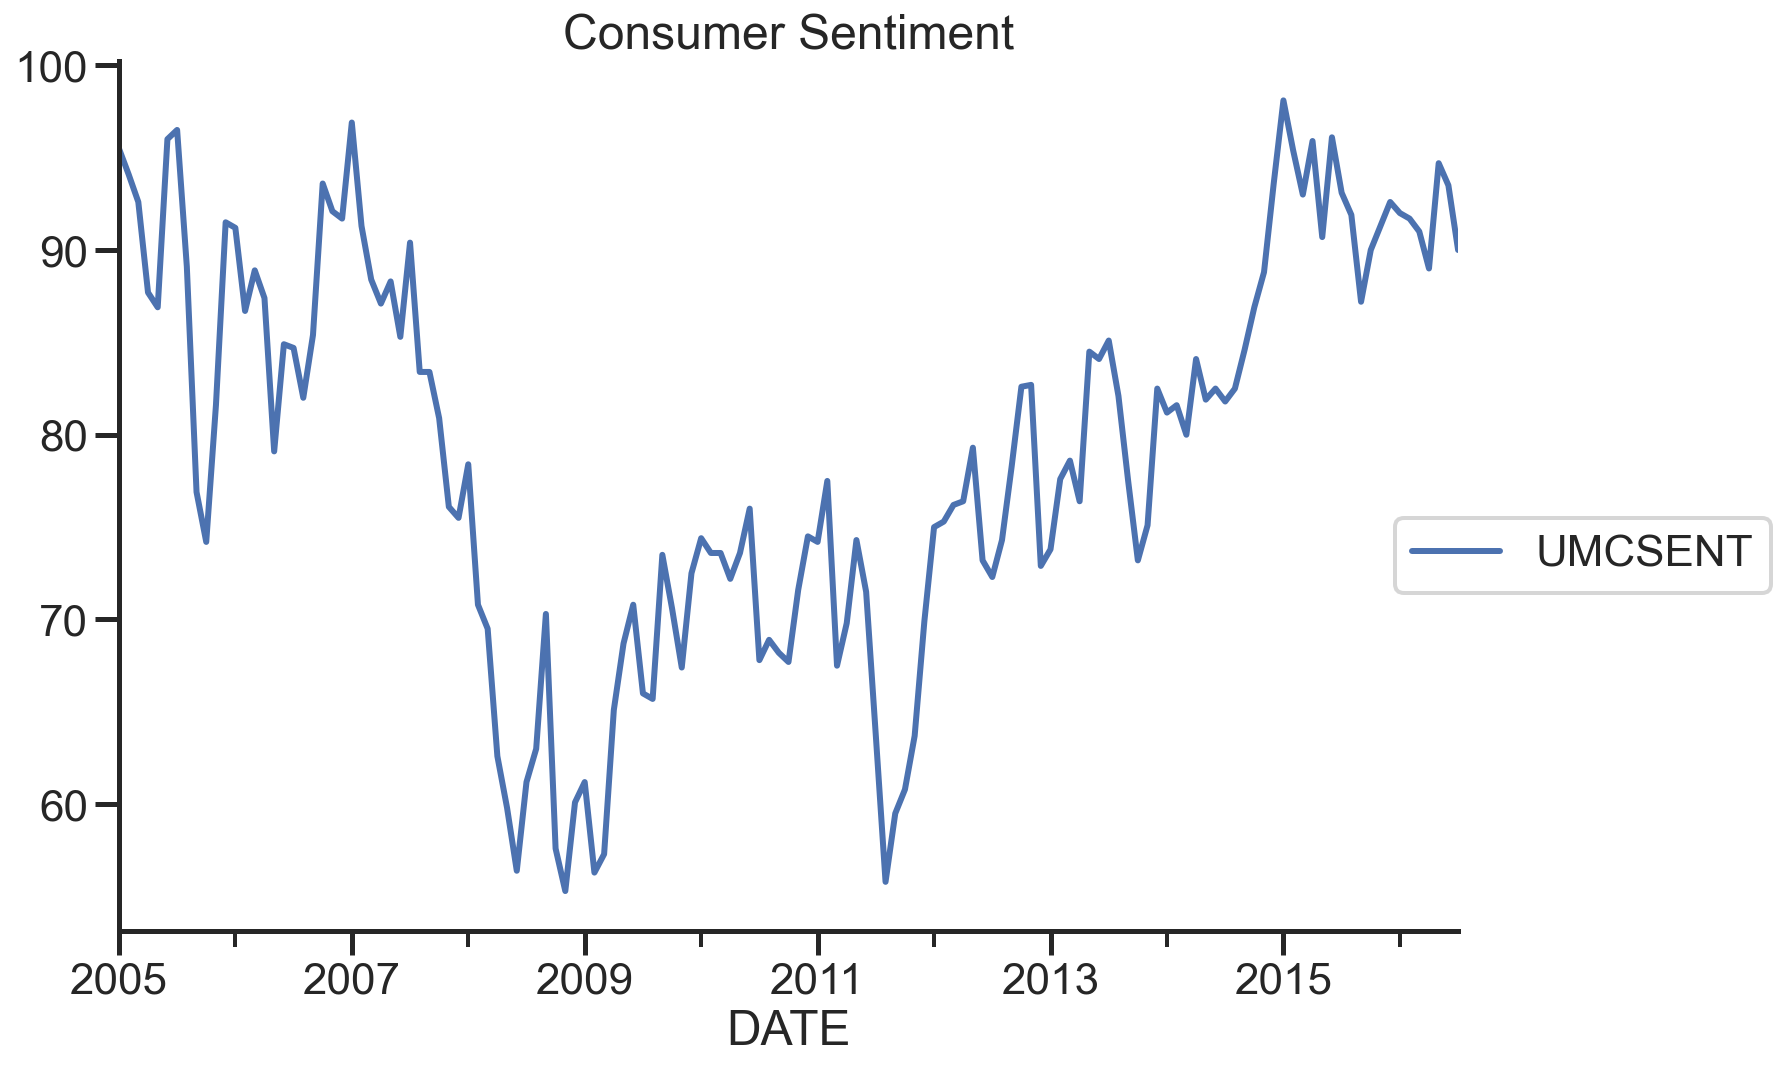

In [191]:
sentiment_short.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5)) # legend位置
plt.title("Consumer Sentiment")
sns.despine() # Remove the top and right spines from plot(s)

/Users/joey/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/joey/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f876bded610>,
      dtype=object)

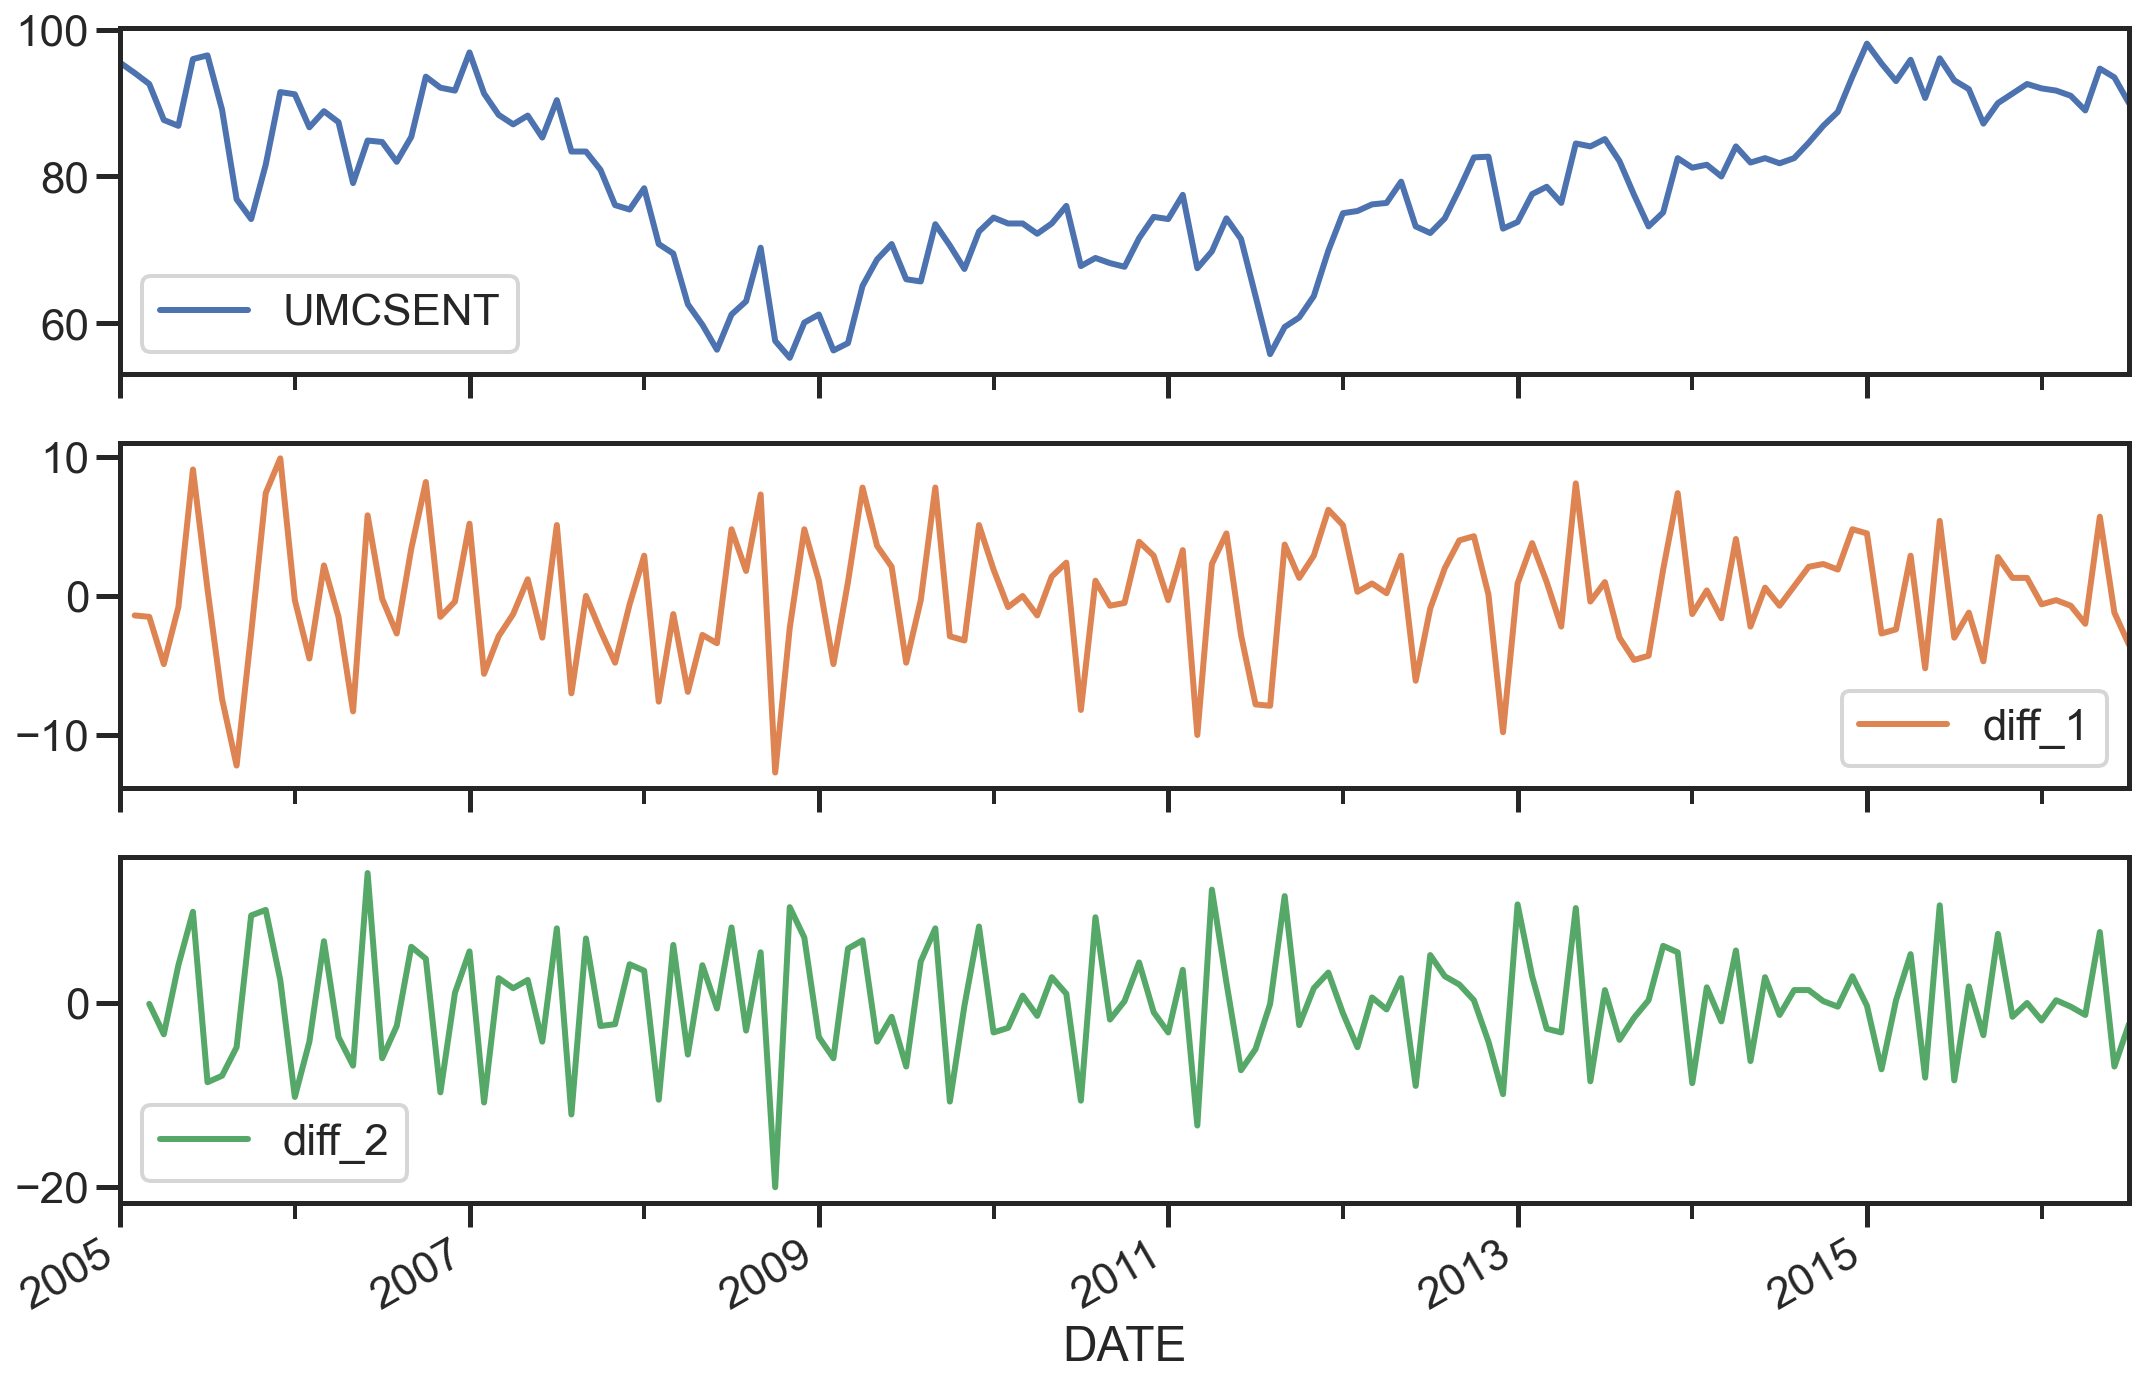

In [192]:
# 二阶差分
sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)
sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)
sentiment_short.plot(subplots=True,figsize=(18,12))


In [193]:
# 删除
del sentiment_short['diff_2']
del sentiment_short['diff_1']
sentiment_short.head()

,UMCSENT
DATE,
2005-01-01,95.5
2005-02-01,94.1
2005-03-01,92.6
2005-04-01,87.7
2005-05-01,86.9


In [194]:
print (type(sentiment_short))

<class 'pandas.core.frame.DataFrame'>


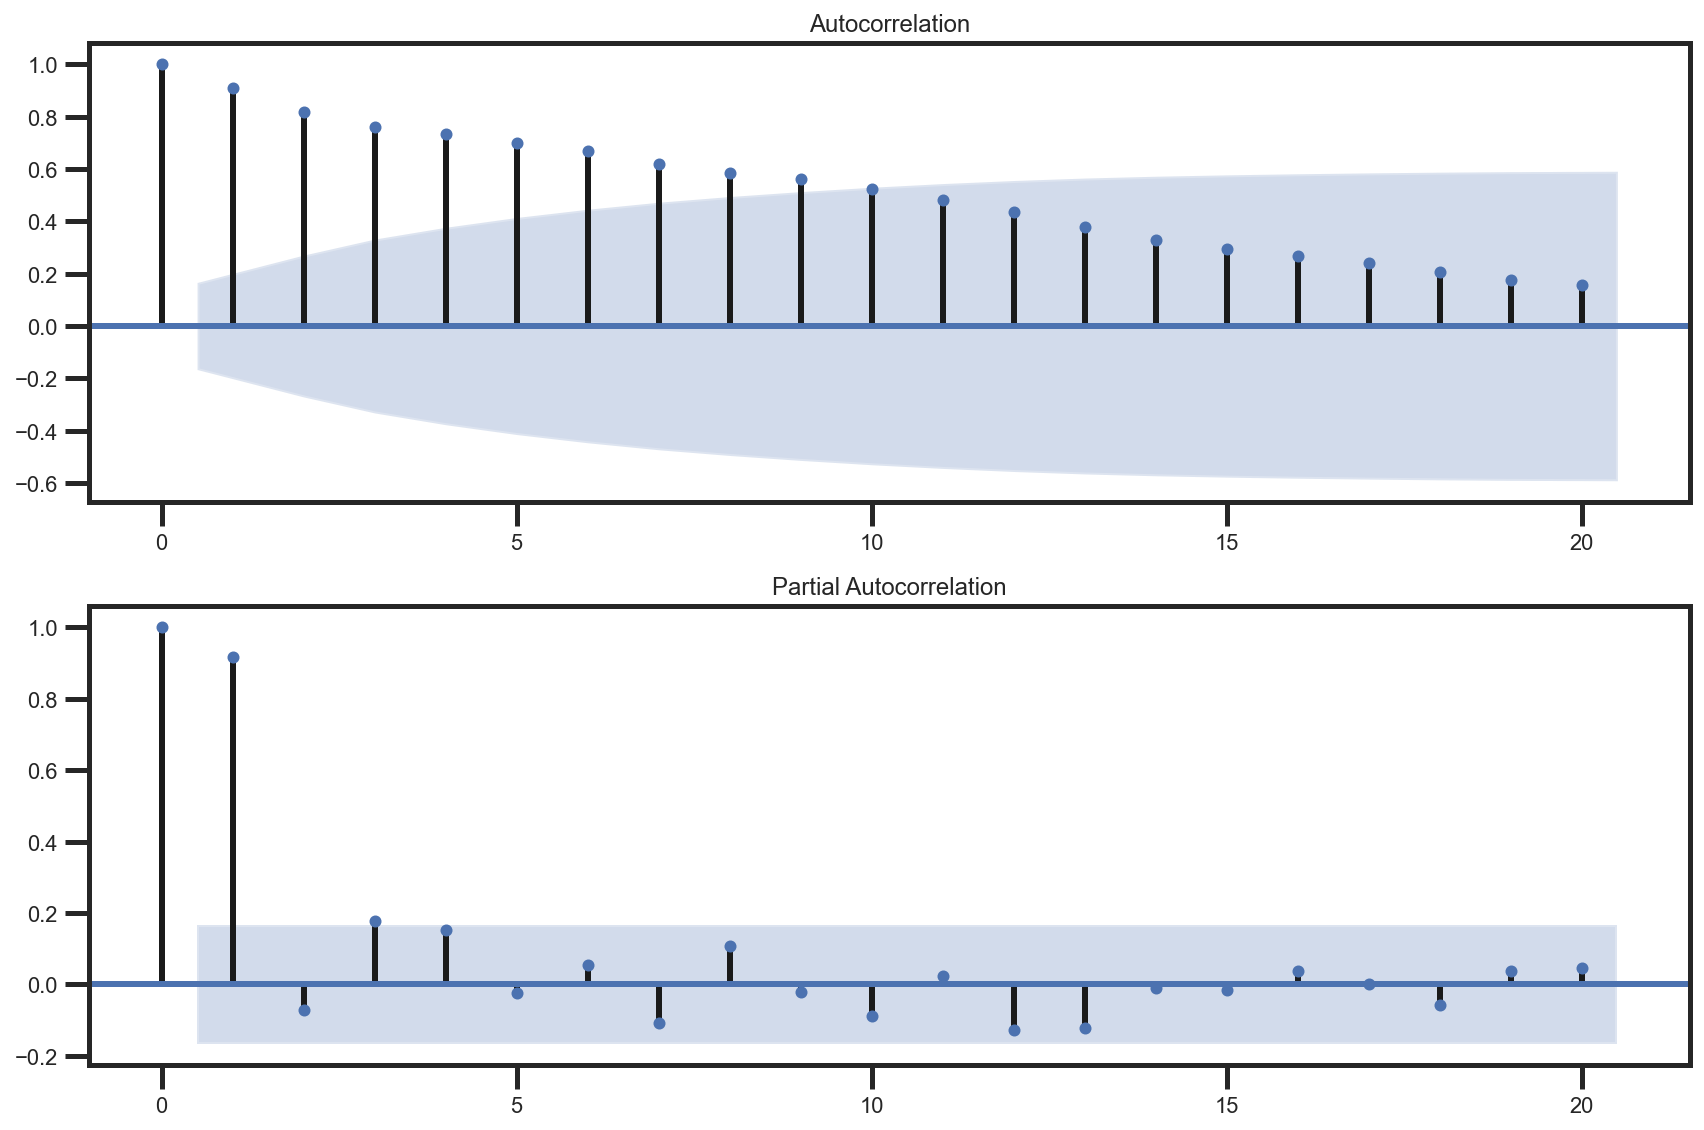

In [241]:
# https://blog.csdn.net/sunnyxidian/article/details/92946542?ops_request_misc=&request_id=&biz_id=102&utm_term=graphics.tsa.plot_acf&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-0-92946542
# 阴影，置信区间
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sentiment_short,lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom') # 坐标轴 把x坐标放在x坐标轴的下面
fig.tight_layout() # 自动调整子图参数，使之填充整个图像区域

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentiment_short, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

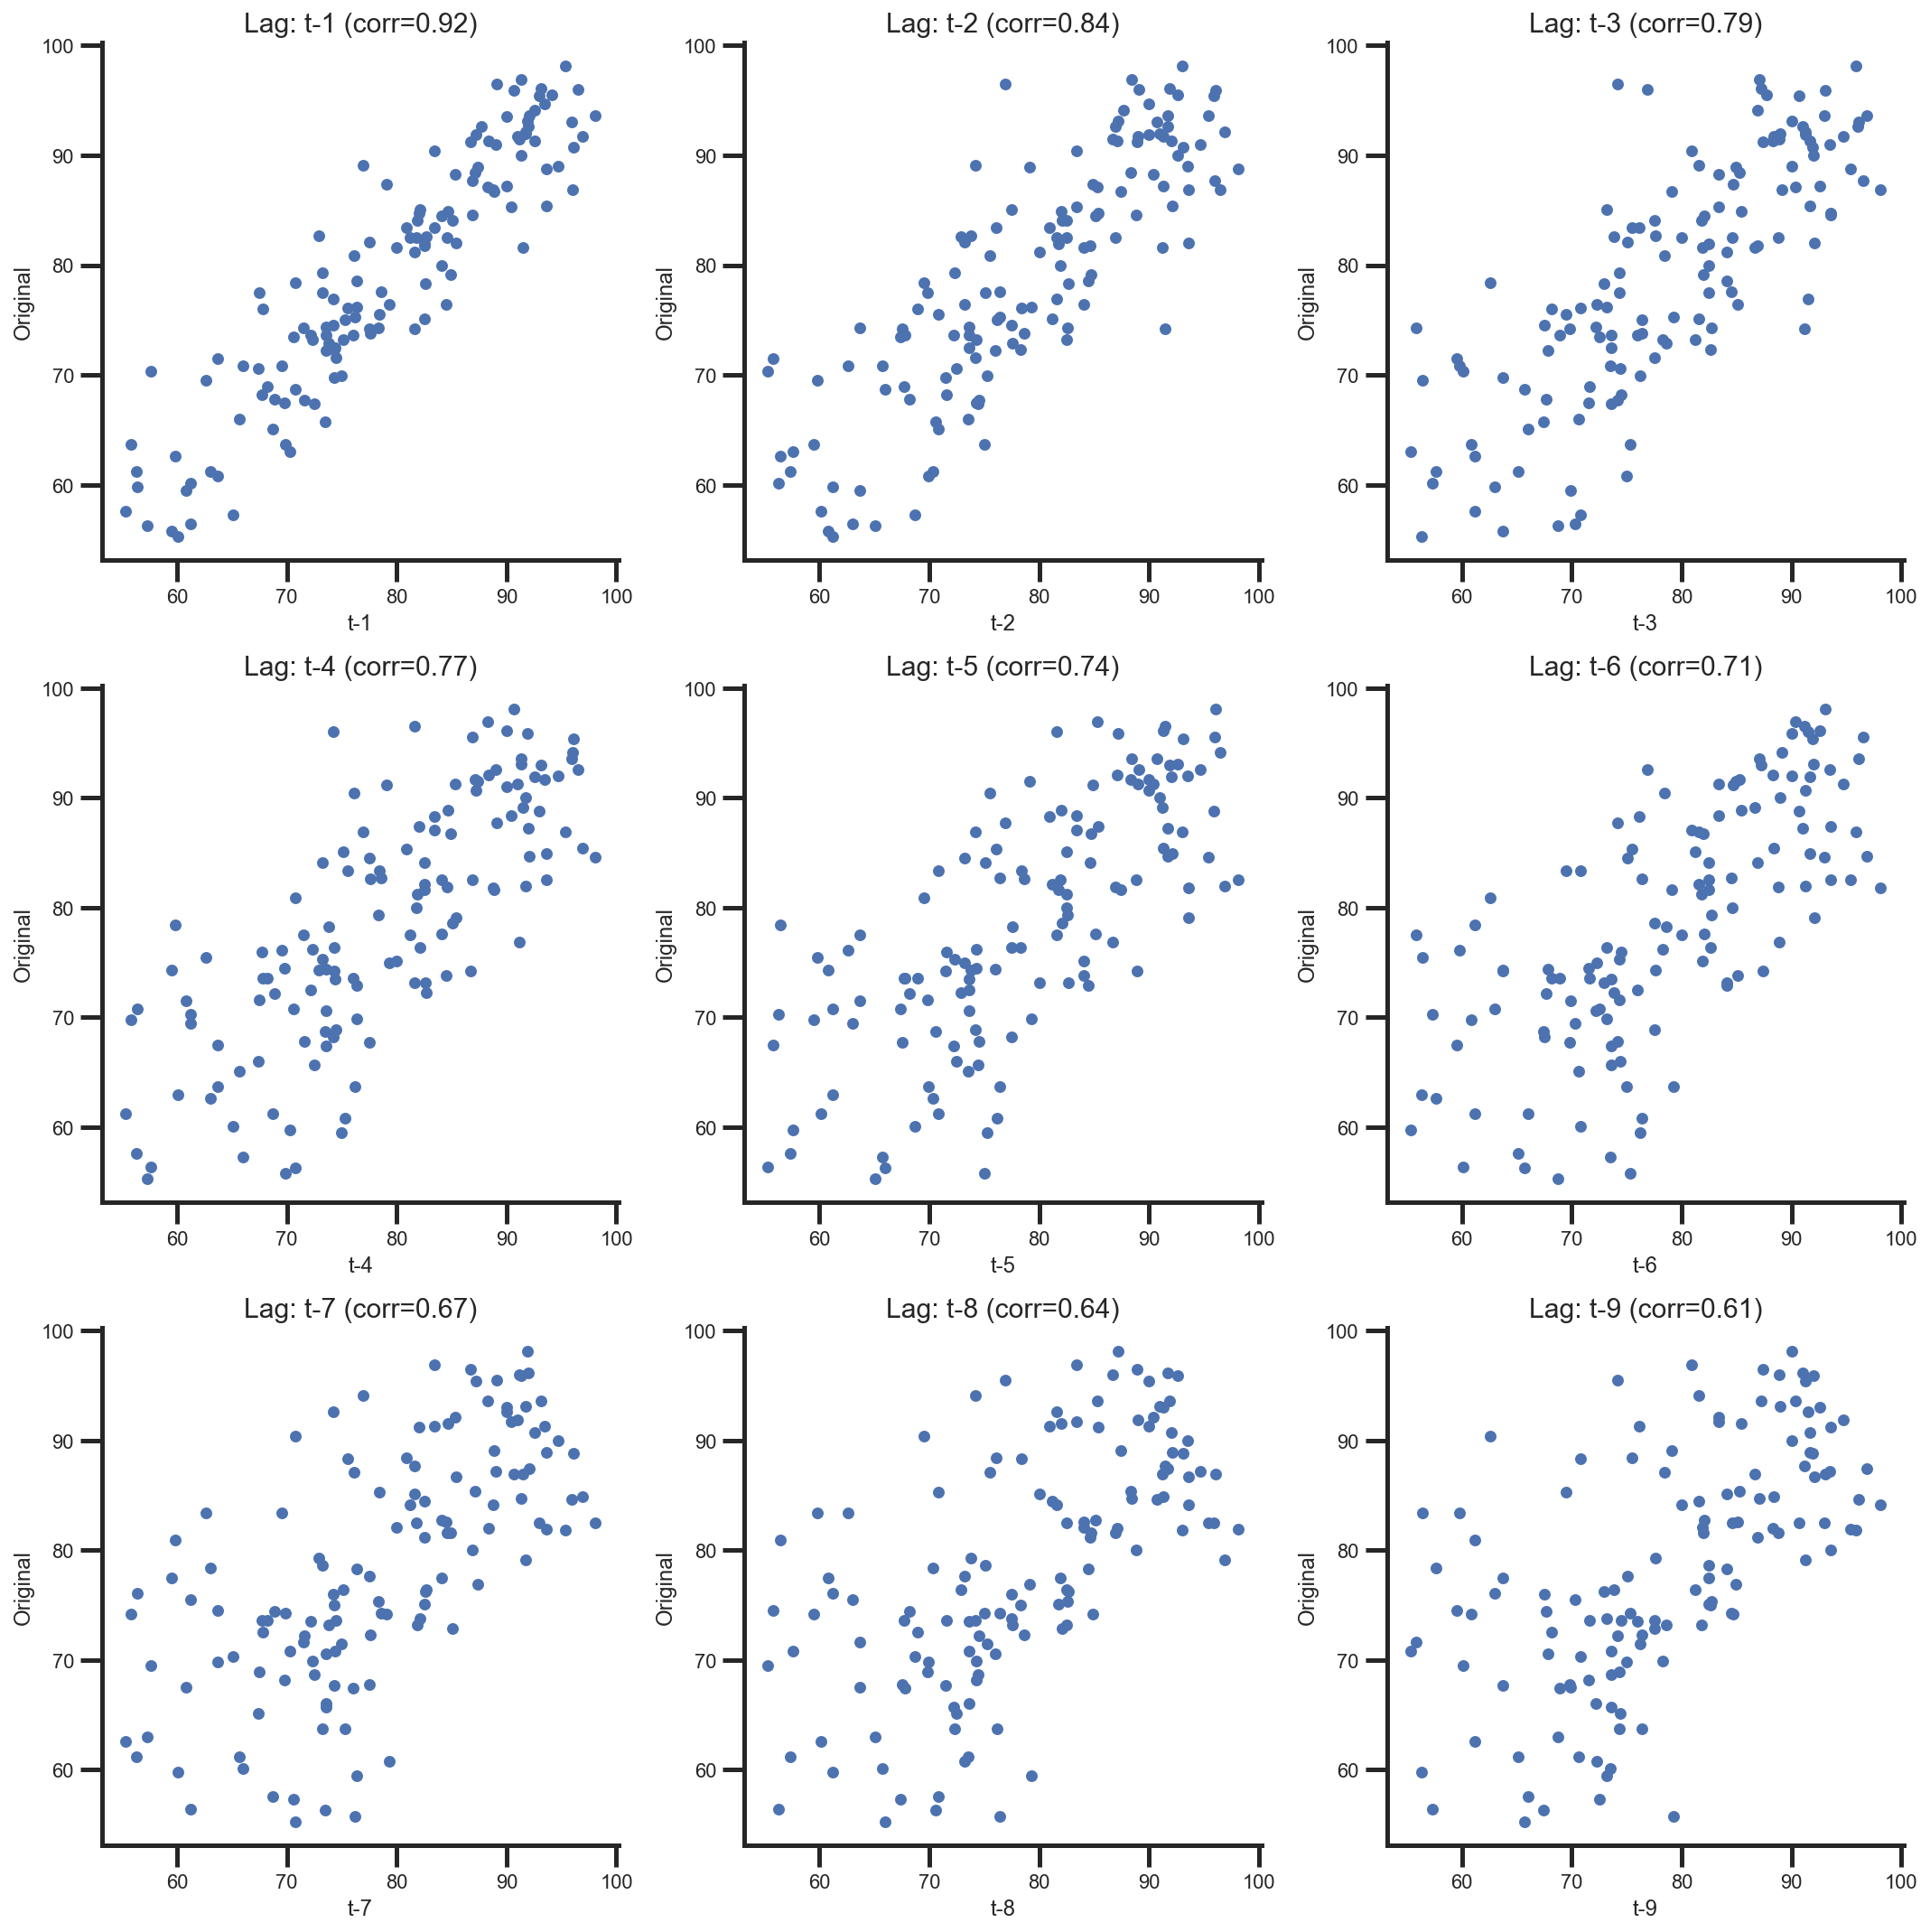

In [242]:
# 散点图表示
lags=9
ncols=3
nrows=int(np.ceil(lags/ncols))
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(5*ncols,5*nrows))

for ax ,lag in zip(axes.flat,np.arange(1,lags+1,1)):

    lag_str = 't-{}'.format(lag)
    X = (pd.concat([sentiment_short,sentiment_short.shift(-lag)],axis=1,
                   keys=['y']+[lag_str]).dropna())
    X.plot(ax=ax,kind='scatter',y='y',x=lag_str);
    corr = X.corr().iloc[0,1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr),fontsize=15);
    ax.set_aspect('equal');
    sns.despine();

fig.tight_layout();

,,y,t-9
,,UMCSENT,UMCSENT
y,UMCSENT,1.00000,0.61183
t-9,UMCSENT,0.61183,1.00000


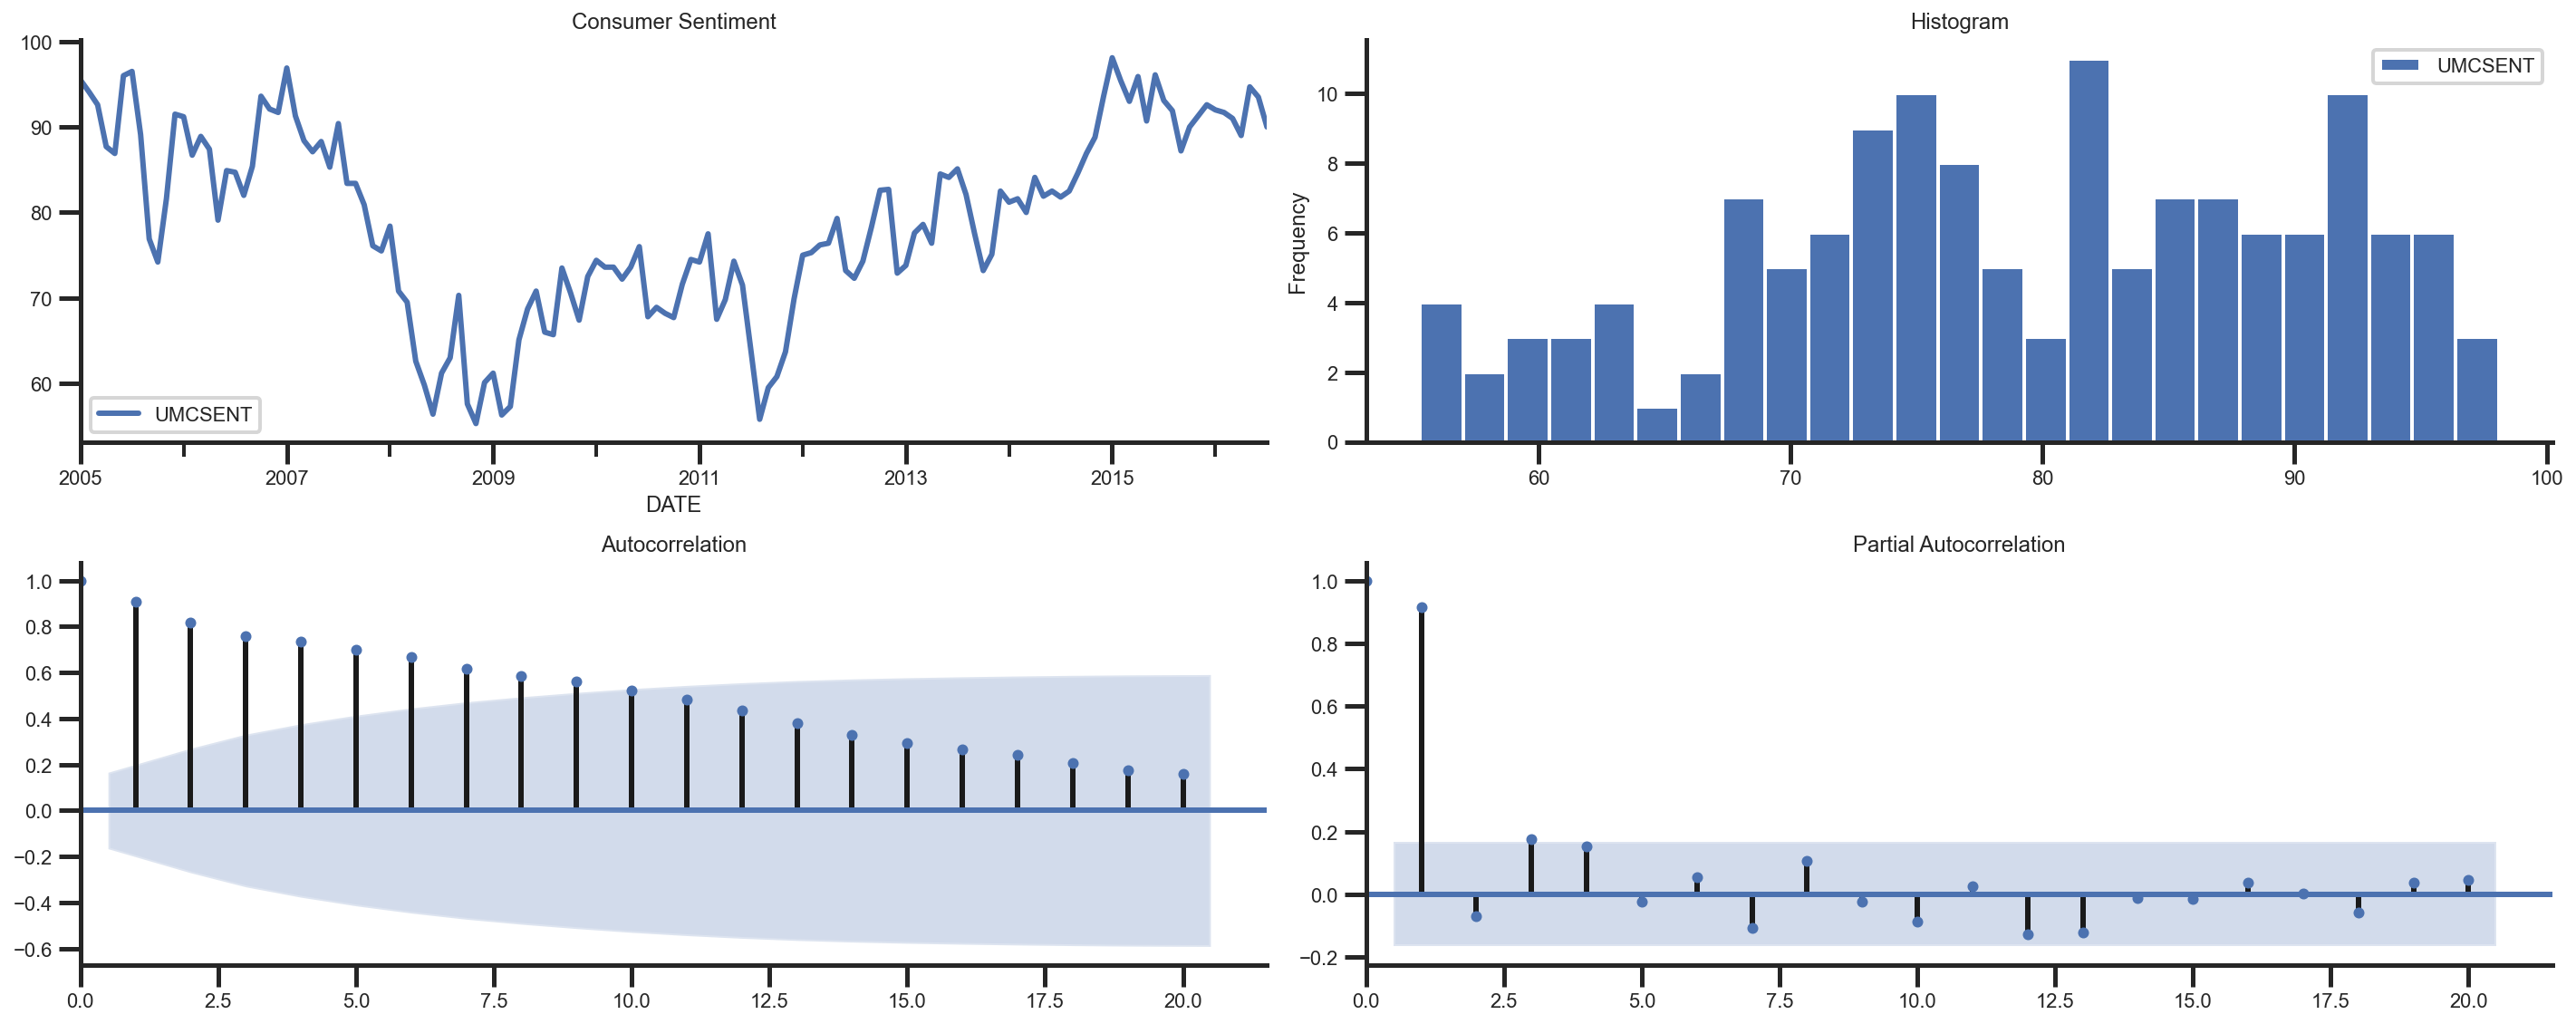

In [243]:
# 更加直观（模板）
def tsplot(y, lags=None, title='', figsize=(20,8)):
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout,(0,0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)

    y.plot(ax=hist_ax,kind='hist',bins=25)
    hist_ax.set_title('Histogram')

    smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
    smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)

    [ax.set_xlim(0) for ax in [acf_ax,pacf_ax]]
    sns.despine()
    plt.tight_layout()

tsplot(sentiment_short,title='Consumer Sentiment',lags=20)

In [249]:
# 更换数据series1.csv
filename_ts = '/Users/joey/Documents/PycharmProjects/mywork/timeseries/series1.csv'
ts_df = pd.read_csv(filename_ts,index_col=0,parse_dates=[0])
n_sample = ts_df.shape[0]

In [250]:
print(ts_df.shape)
print(ts_df.head())

(120, 1)
               value
2006-06-01  0.215066
2006-07-01  1.142246
2006-08-01  0.080771
2006-09-01 -0.739519
2006-10-01  0.535516


In [251]:
# Create a training sample and testing sample before analyzing the series
n_train = int(0.95 * n_sample) + 1
n_forecast = n_sample-n_train

ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(115,)
(5,)
Training Series: 
 2015-08-01    0.603715
2015-09-01   -1.273721
2015-10-01   -0.932841
2015-11-01    0.085515
2015-12-01    1.205344
Name: value, dtype: float64 

Testing Series: 
 2016-01-01    2.164111
2016-02-01    0.952261
2016-03-01    0.364852
2016-04-01   -2.264869
2016-05-01   -2.381679
Name: value, dtype: float64


In [252]:
def tsplot(y, lags=None, title='', figsize=(20, 8)):


    fig = plt.figure(figsize=figsize)
    # plt.tick_params(labelsize=.1)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]

    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

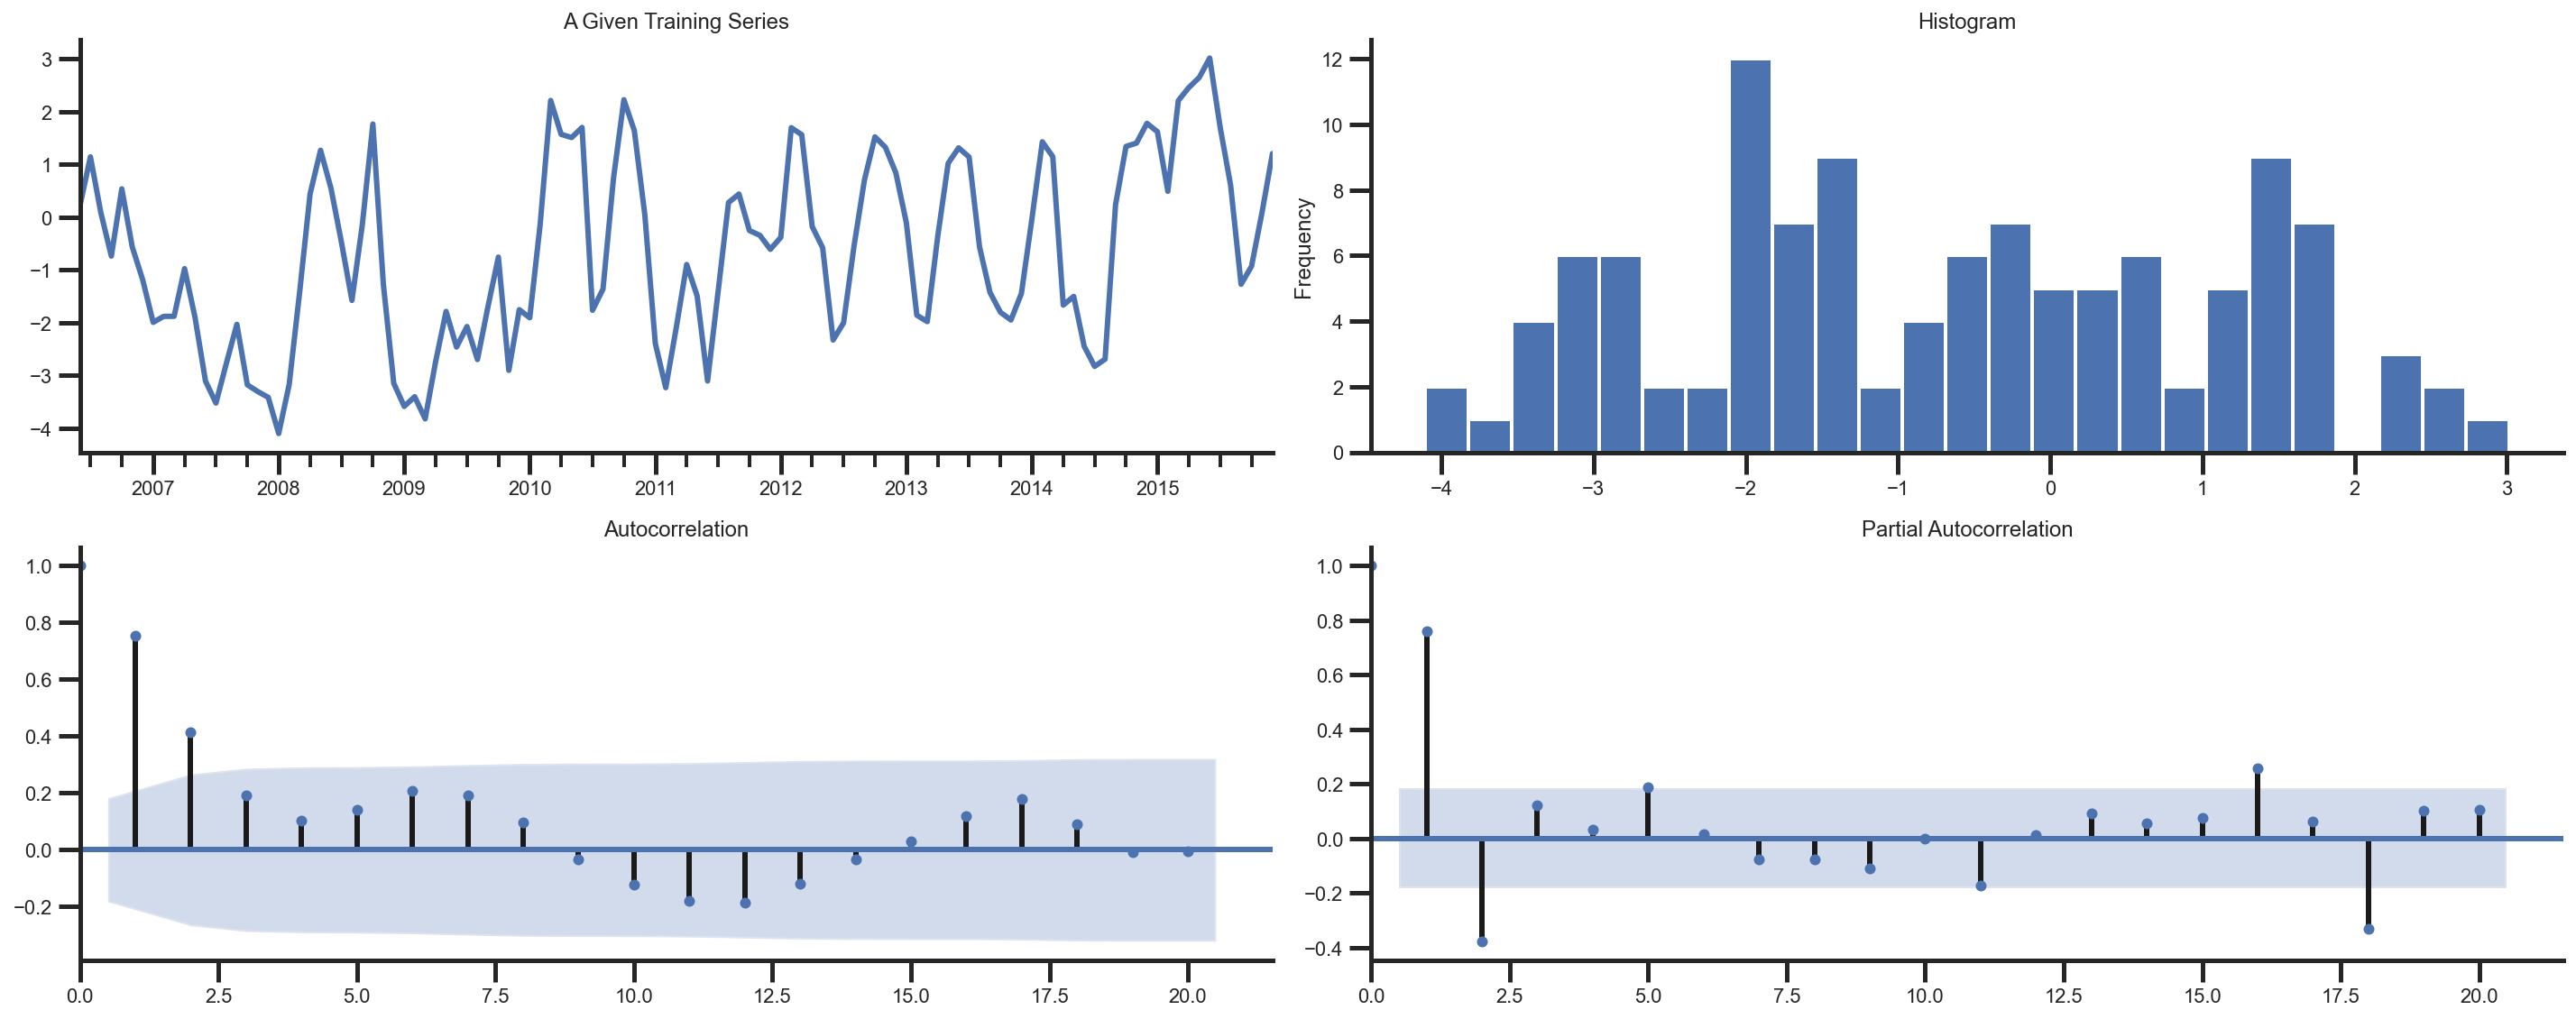

In [253]:
tsplot(ts_train, title='A Given Training Series', lags=20);


In [254]:
arima200 = sm.tsa.SARIMAX(ts_train,order=(2,0,0))
model_results = arima200.fit()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


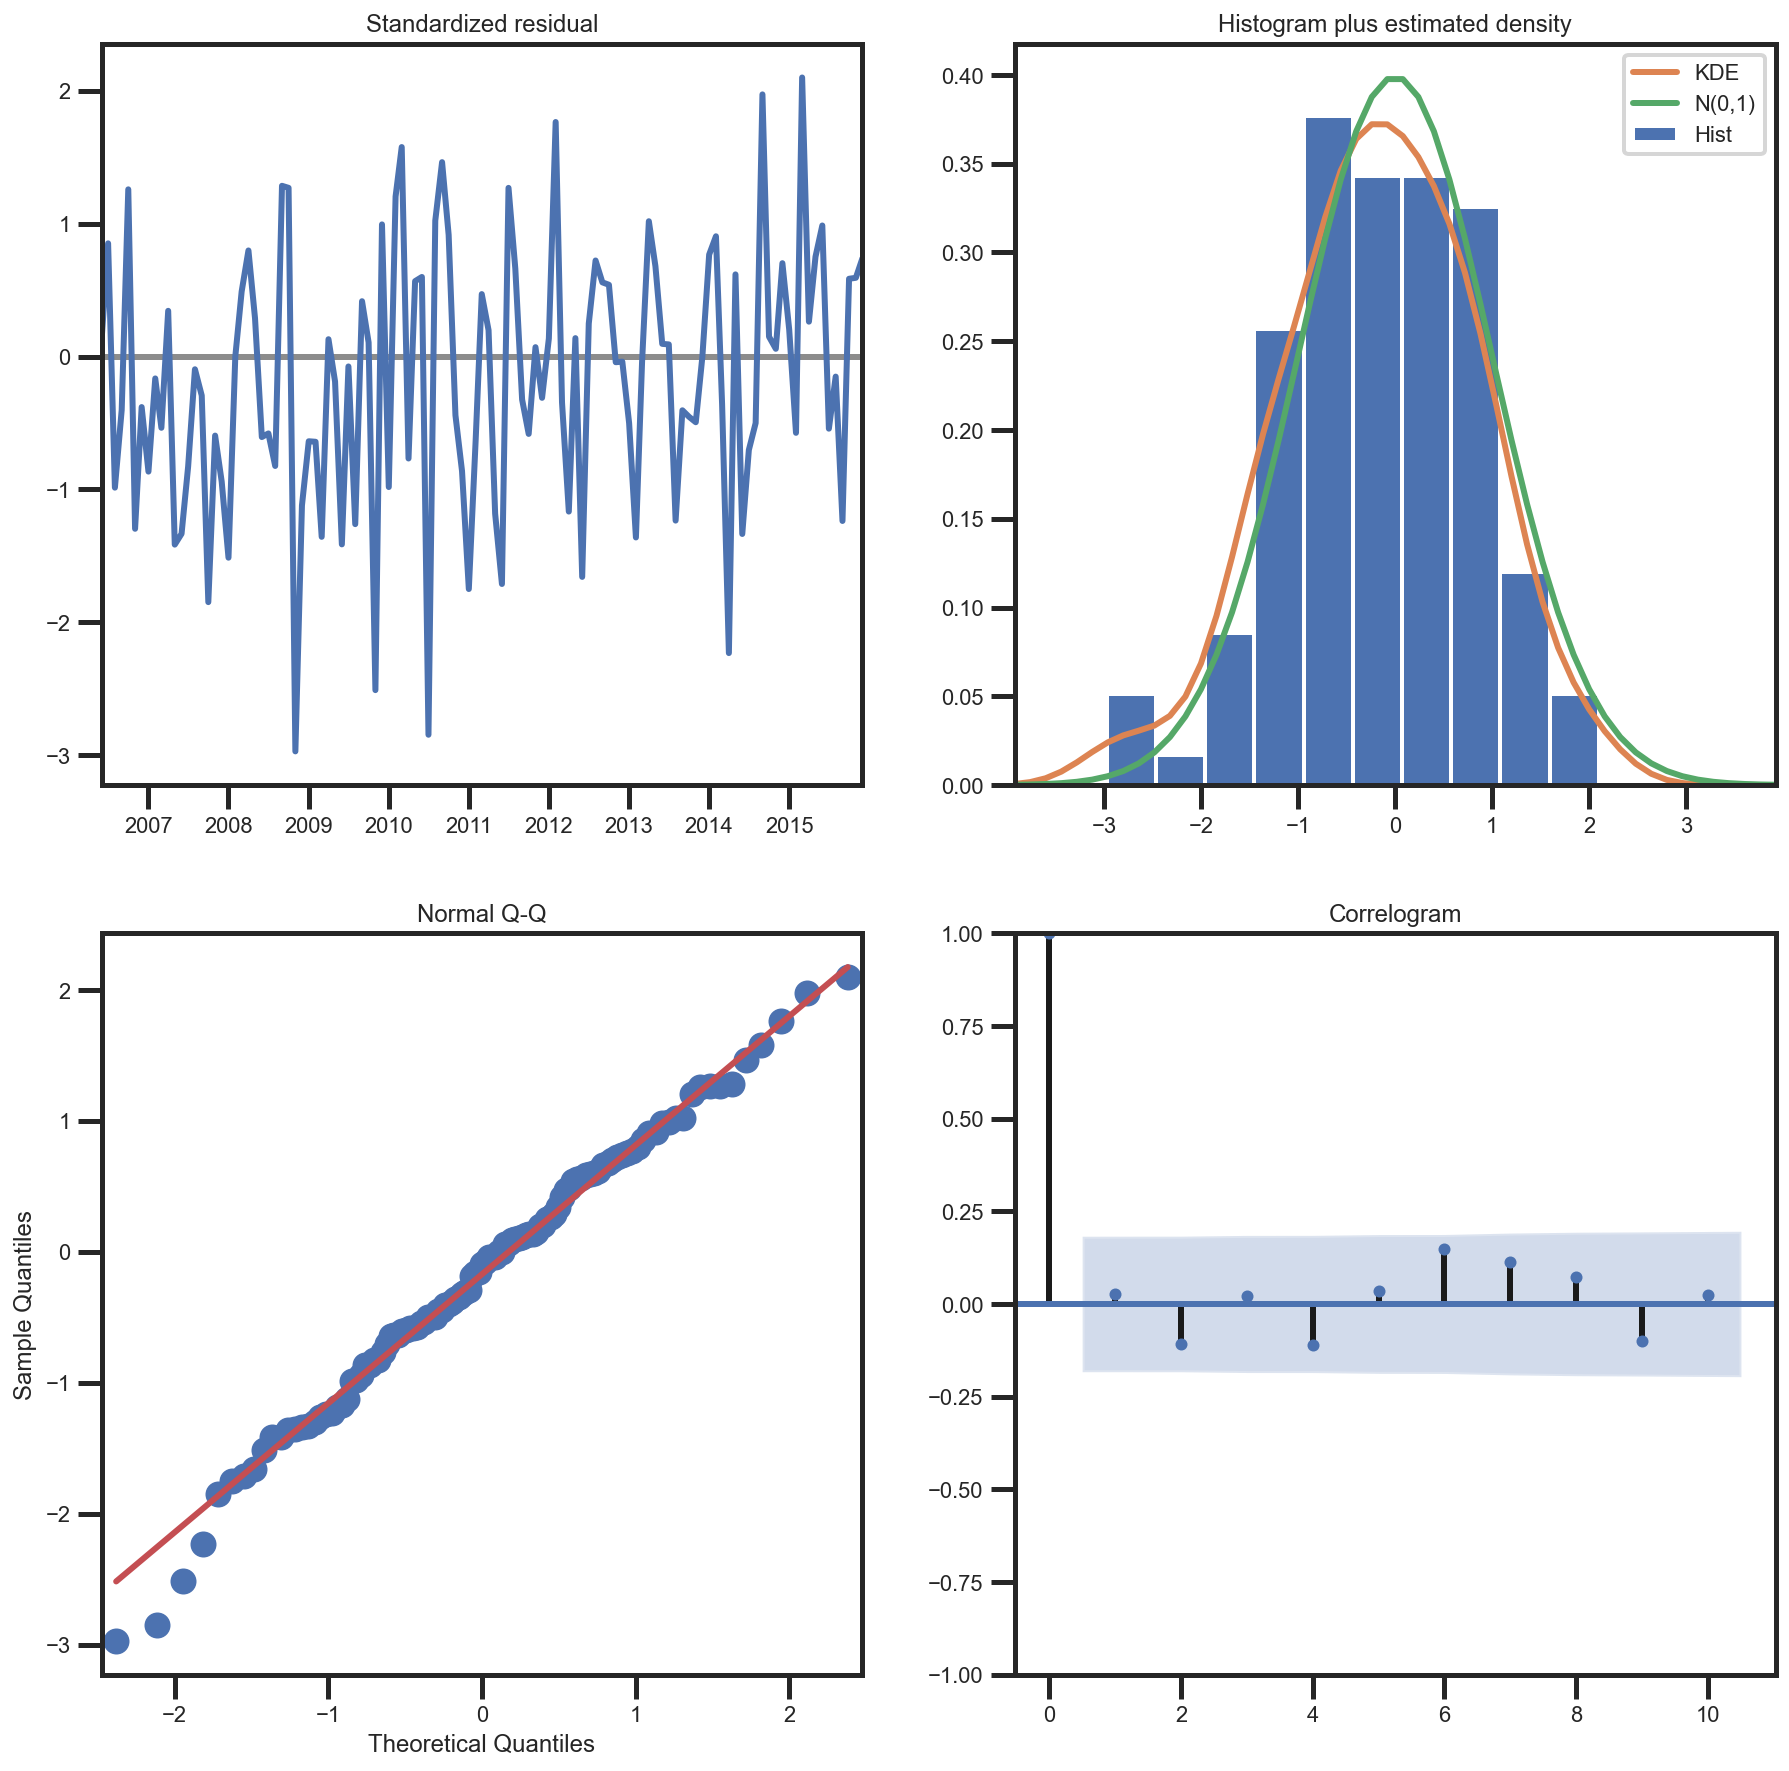

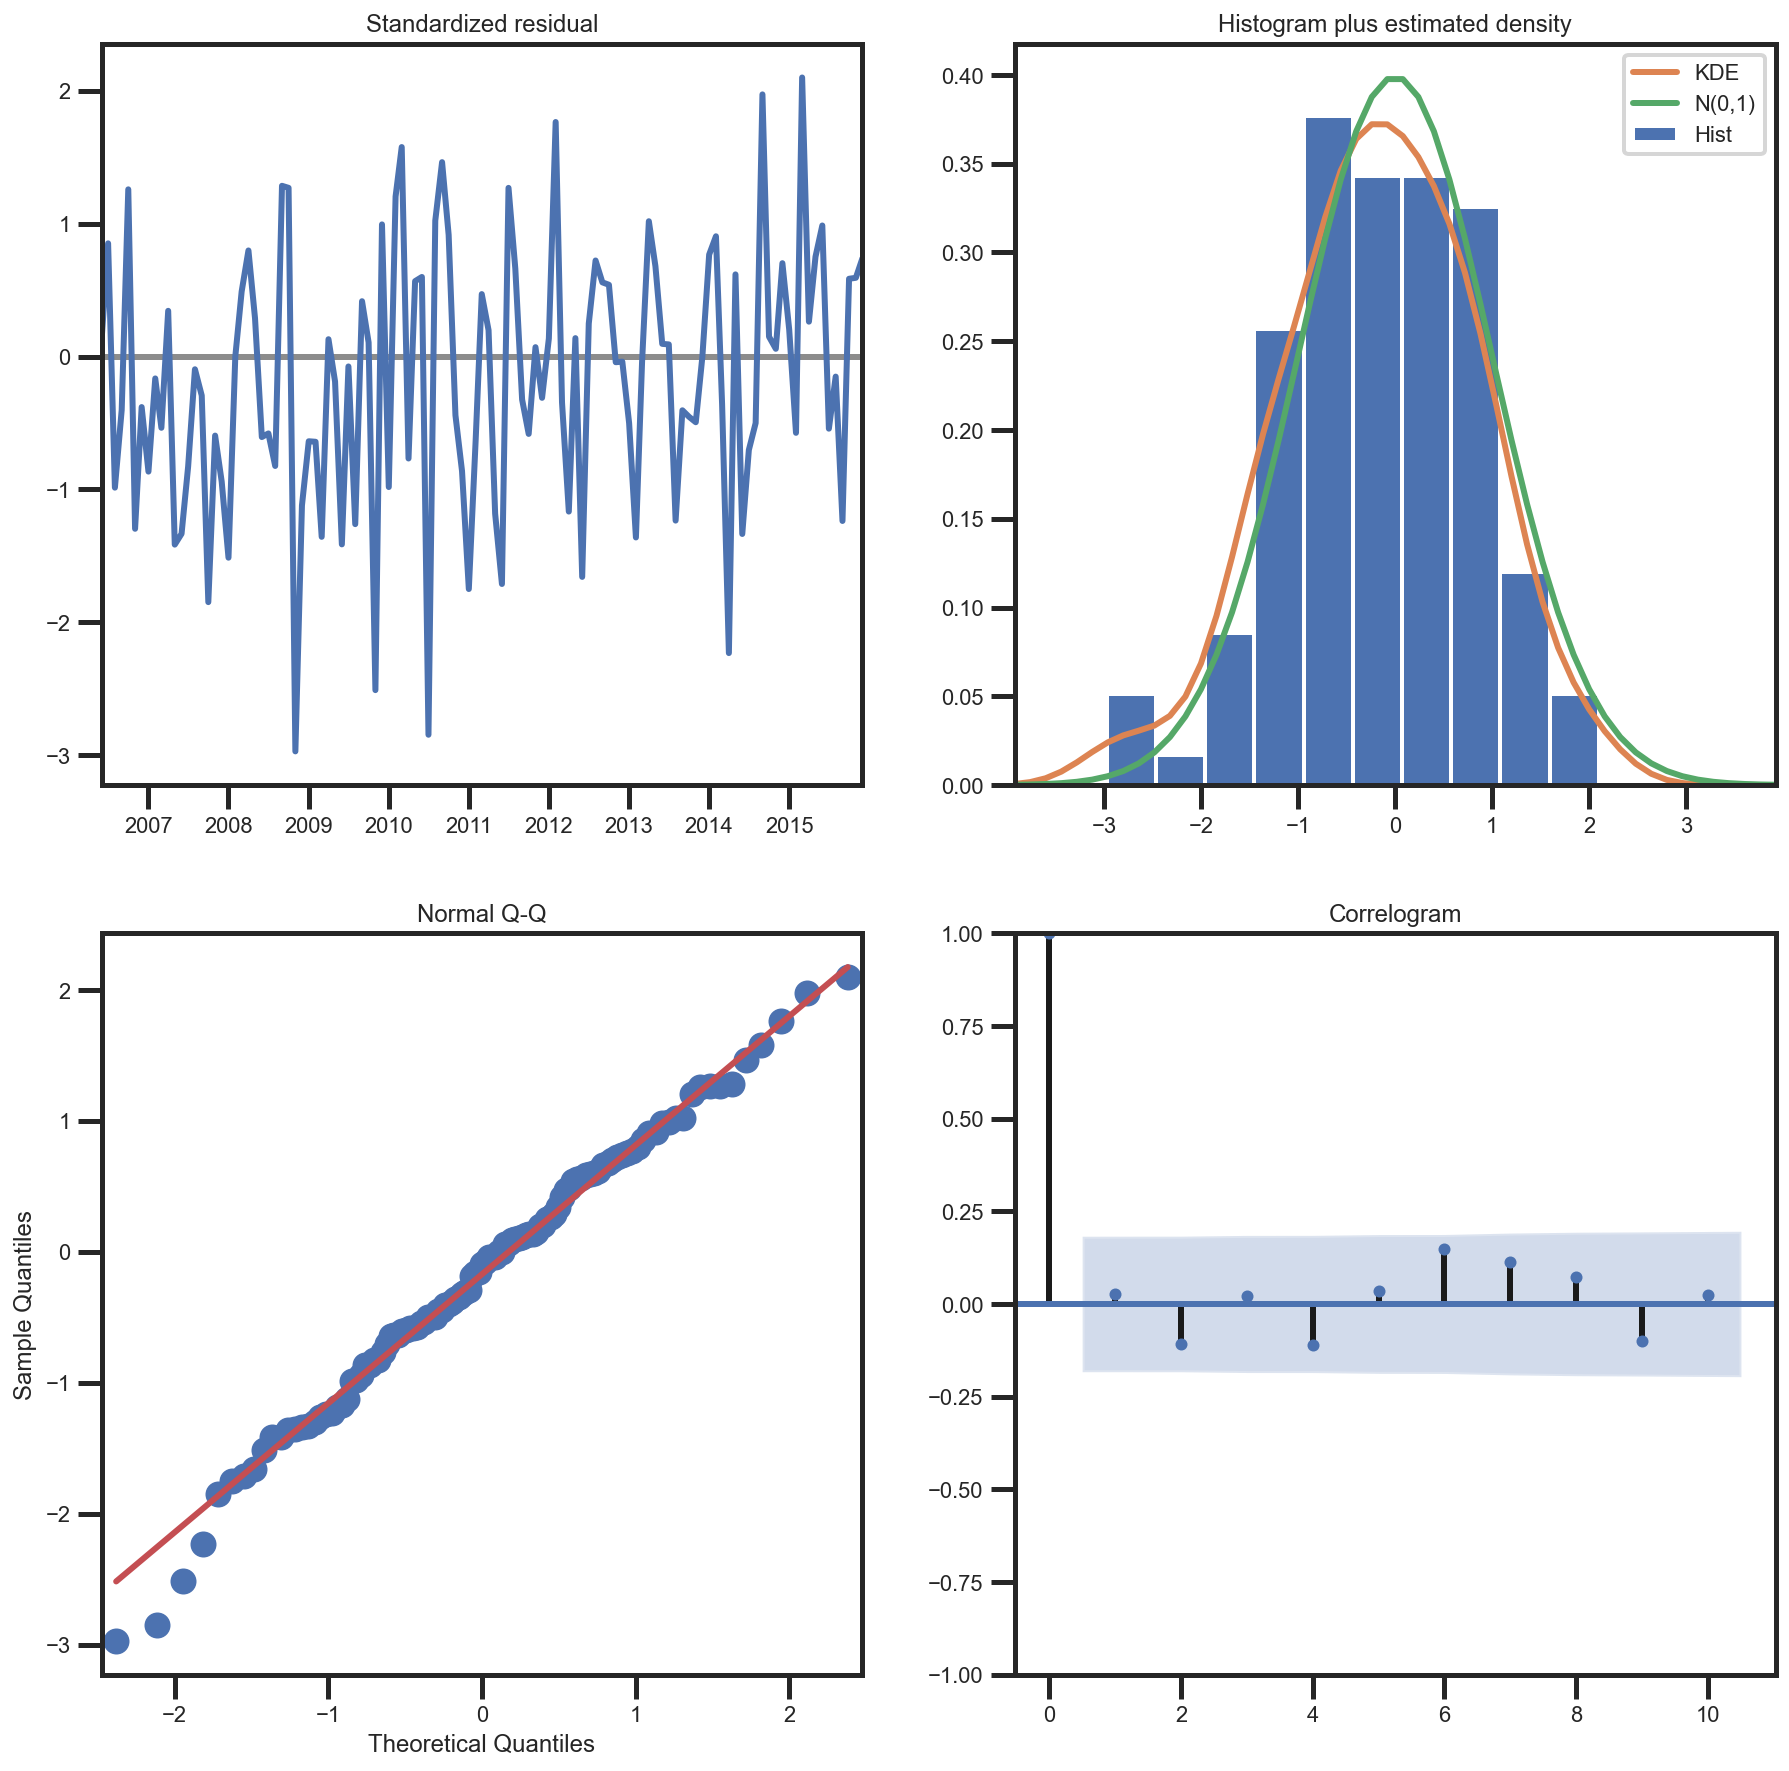

In [255]:
model_results.plot_diagnostics(figsize=(15,15))

In [268]:
# 参数的选择

import itertools

# 可能的参数范围
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
# 产生迭代器
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue

    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              );
        results = model.fit();
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float);

Text(0.5, 1.0, 'BIC')

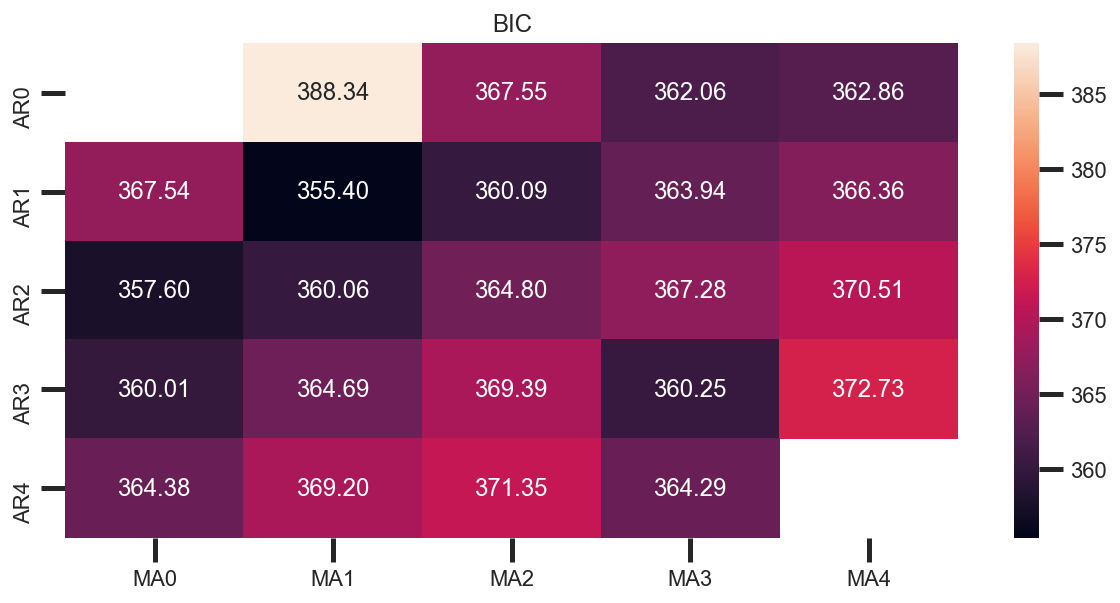

In [257]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
sns.heatmap(results_bic,mask=results_bic.isnull(),
            annot=True,fmt='.2f');
ax.set_title('BIC')

In [258]:
# Alternative model selection method, limited to only searching AR and MA parameters
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4);
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:69

AIC (4, 2)
BIC (1, 1)


In [65]:
arima200 = sm.tsa.SARIMAX(ts_train,order=(4,2,0))
model_results = arima200.fit()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


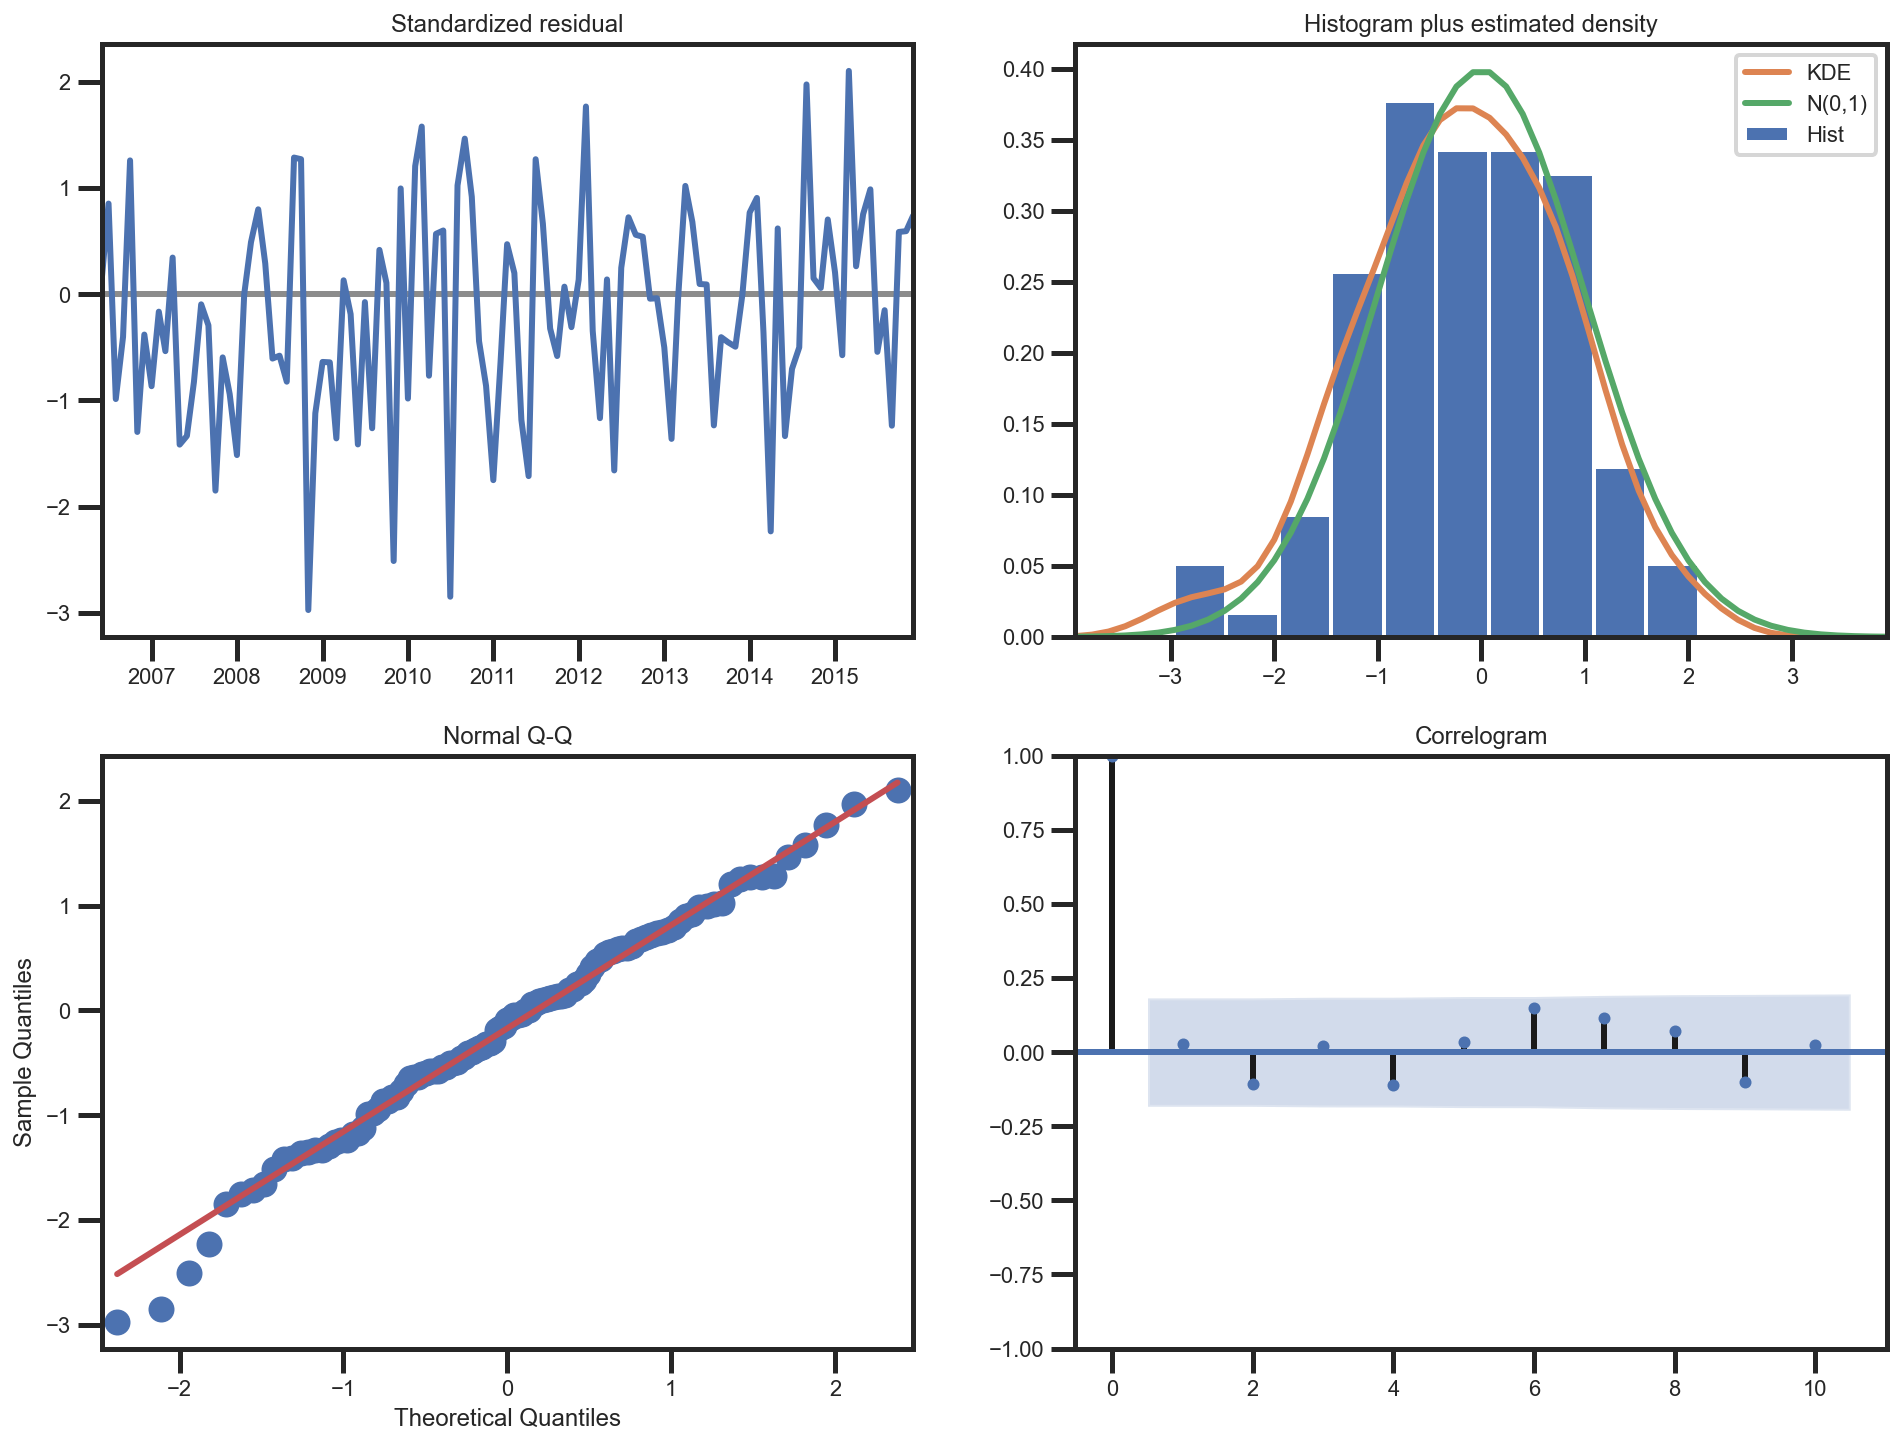

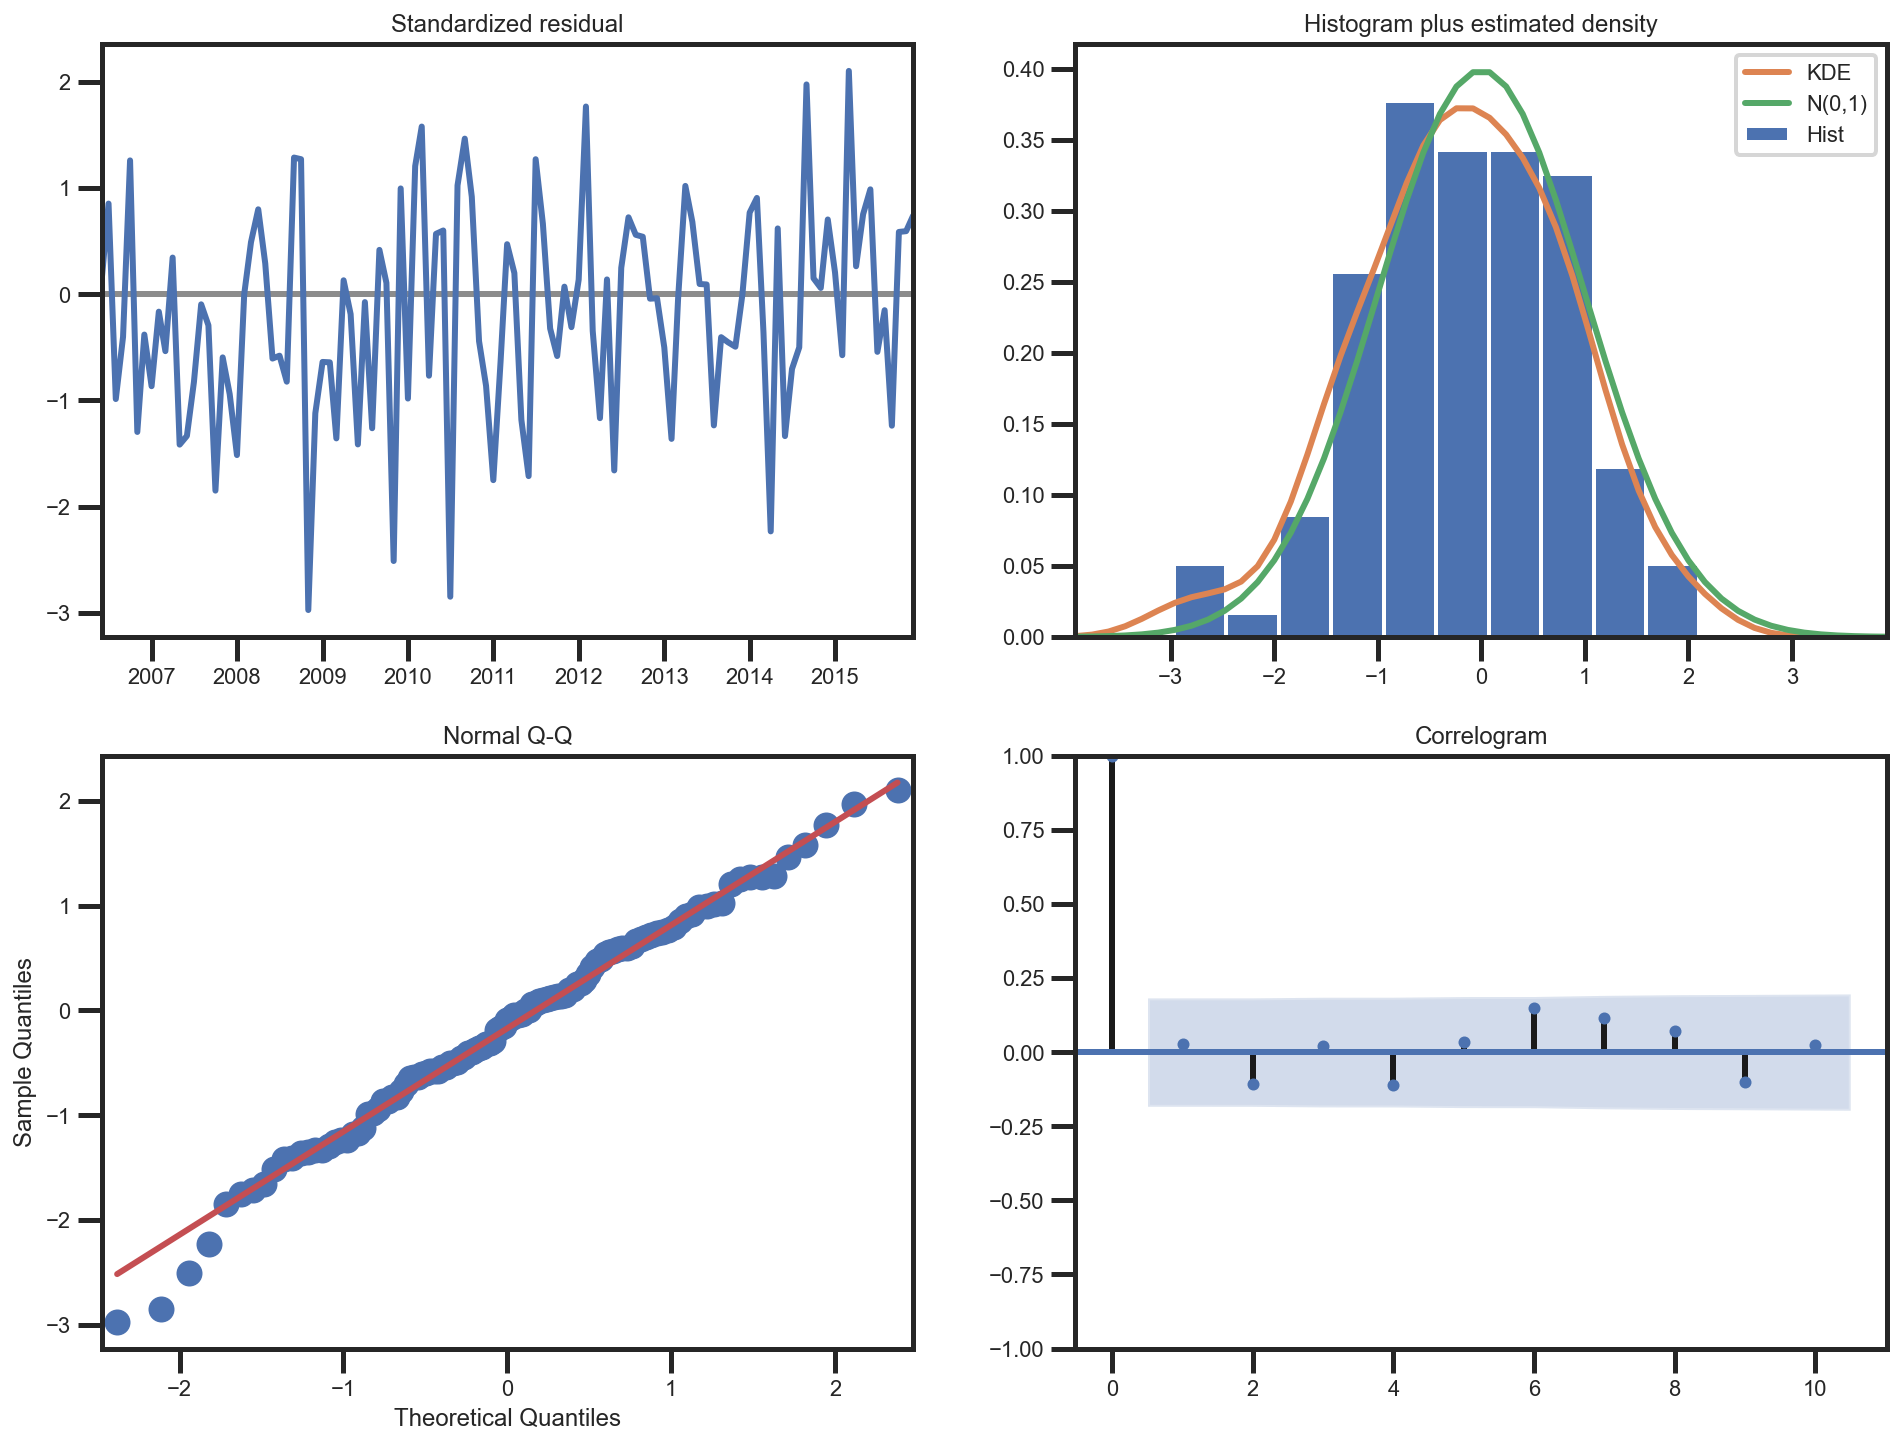

In [263]:
#残差分析 正态分布 QQ图线性
model_results.plot_diagnostics(figsize=(16,12))